Joshua Pauly 
Assignment 2 Image classification

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# From Keras testing if image is corrupted
import os

num_skipped = 0
for folder_name in ("buildings", "forest", "glacier", "mountain", "sea", "street"):
    folder_path = os.path.join("seg_train\seg_train",folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [3]:
img_size = (224,224)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "seg_train\seg_train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=img_size,
    batch_size=batch_size,
)



Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Using 2806 files for validation.


In [5]:
test_images = tf.keras.utils.image_dataset_from_directory(
    "seg_test\seg_test",
    seed=1337,
    image_size=img_size
)

Found 3000 files belonging to 6 classes.


Visualize the first 25 images

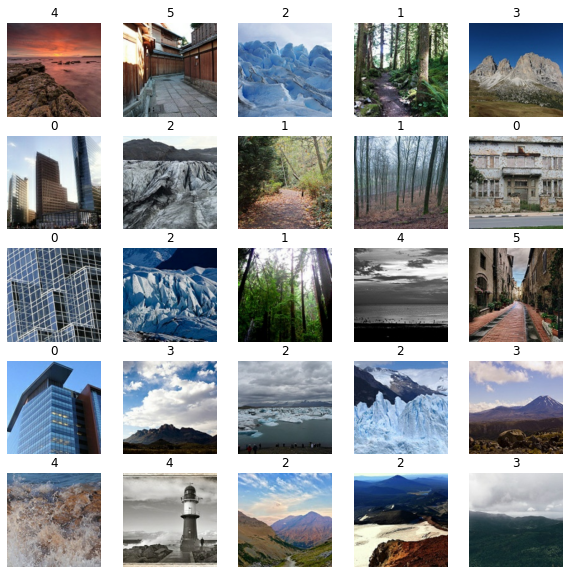

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Image augmentation is used to increase training set and randomly shift images

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(0.14,0.14),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ]
)

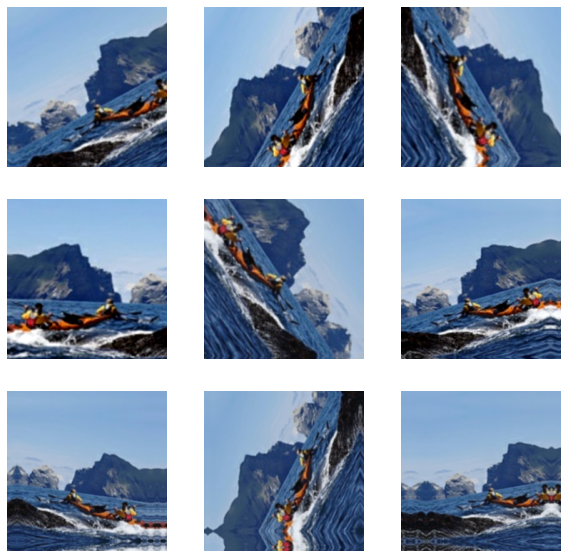

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Fix RGB Channel

In [10]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Apply data augmentation to training set

In [11]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [12]:
CB = [
            keras.callbacks.ModelCheckpoint(
            filepath="fine_tuning.keras",
            save_best_only=True,
            monitor="val_loss"),
    
            keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0005,
            patience=10)
]

In [13]:
# VGG16 Model
vgg16_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    #weights=None,
    include_top=False)

#vgg16_base.trainable = True
vgg16_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg16_base.trainable_weights))

vgg16_base.summary()

This is the number of trainable weights before freezing the conv base: 0
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                      

In [17]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg16_base(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
vgg16_model = keras.Model(inputs, outputs)
vgg16_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0   

In [18]:
def plot_history(history,title=''):  
    if title!='':
        title+=' '
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    #Loss
    sns.lineplot(data = history.history['loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history.history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title(title+'Loss')
    #Accuracy
    sns.lineplot(data = history.history['accuracy'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history.history['val_accuracy'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title(title+'Accuracy')

In [19]:
history_vgg16 = vgg16_model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=CB
    )
vgg16_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/15
88/88 [==============================] - 1394s 16s/step - loss: 1.0952 - accuracy: 0.6169 - val_loss: 0.5049 - val_accuracy: 0.8788
Epoch 2/15
88/88 [==============================] - 1008s 11s/step - loss: 0.6468 - accuracy: 0.7661 - val_loss: 0.3834 - val_accuracy: 0.9009
Epoch 3/15
88/88 [==============================] - 1116s 13s/step - loss: 0.5523 - accuracy: 0.8041 - val_loss: 0.3316 - val_accuracy: 0.9024
Epoch 4/15
88/88 [==============================] - 1175s 13s/step - loss: 0.5130 - accuracy: 0.8164 - val_loss: 0.3180 - val_accuracy: 0.9066
Epoch 5/15
88/88 [==============================] - 1319s 15s/step - loss: 0.4782 - accuracy: 0.8284 - val_loss: 0.2843 - val_accuracy: 0.9105
Epoch 6/15
88/88 [==============================] - 1271s 14s/step - loss: 0.4691 - accuracy: 0.8281 - val_loss: 0.2819 - val_accuracy: 0.9081
Epoch 7/15
88/88 [==============================] - 1391s 16s/step - loss: 0.4596 - accuracy: 0.8352 - val_loss: 0.2812 - val_accuracy: 0.9077

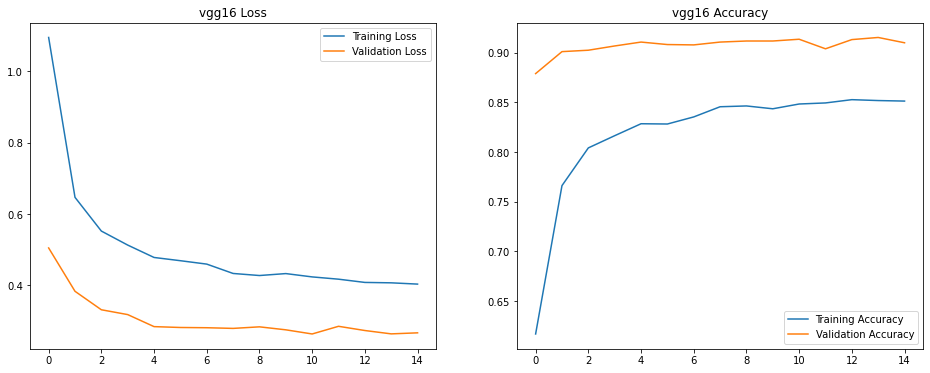

In [21]:
plot_history(history_vgg16,'vgg16')

In [25]:
#VGG19 Model
vgg19_base  = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False)

#vgg19_base.trainable = True
vgg19_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg19_base.trainable_weights))

vgg19_base.summary()

This is the number of trainable weights before freezing the conv base: 0
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                      

In [26]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg19.preprocess_input(x)
x = vgg19_base(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256,activation='softplus')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation="softmax")(x)
vgg19_model = keras.Model(inputs, outputs)
vgg19_model.compile(optimizer="rmsprop",
               loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0   

In [ ]:
history_vgg19 = vgg19_model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=CB
    )
vgg19_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/15
88/88 [==============================] - 2112s 24s/step - loss: 1.0150 - accuracy: 0.6510 - val_loss: 0.6605 - val_accuracy: 0.8792
Epoch 2/15
88/88 [==============================] - 1946s 22s/step - loss: 0.6417 - accuracy: 0.7766 - val_loss: 0.4733 - val_accuracy: 0.8991
Epoch 3/15
88/88 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.8028 

In [ ]:
plot_history(history_vgg19,'vgg19')

In [ ]:
vgg16_test=vgg16_model.evaluate(test_images)
vgg19_test=vgg19_model.evaluate(test_images)
compare_table=pd.DataFrame([vgg16_test,vgg19_test],columns=['loss','accuracy'],index=['vgg16','vgg19'])
cm = sns.light_palette("green", as_cmap=True)
compare_table.head().style.background_gradient(cmap=cm)

Sources:
    https://www.kaggle.com/code/concyclics/0-995-dog-or-cat-vgg-model-introduction
    https://keras.io/examples/vision/image_classification_from_scratch/